In [1]:
#import the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import networkx as nx
from networkx.algorithms.centrality import degree_centrality
from networkx.algorithms.community import girvan_newman

In [2]:
import time

#start ime to be used to calculate how much time it takes to load the dataset. This is done as the dataset is big
start= time.time()

#initiate a list to hold the read in chunks
chunks = []

#read in the dataset and store the chunks of 100 000 rows in the list
for chunk in pd.read_csv('quiz-dataset.csv', chunksize=100000, low_memory=False):
    chunks.append(chunk)



#create a pandas dataframe from all the chunks
df = pd.concat(chunks, axis=0)

#calculate how long it took to load the dataset in seconds. Interesting to see due to the large dataset
print(f"The time it took to load the dataset: {round(time.time() - start, 3)}s")

The time it took to load the dataset: 56.95s


In [3]:
#show all columns and rows when viewing the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#treat 'inf' values as nulls
pd.option_context('mode.use_inf_as_na', True)

In [4]:
#get a copy of the dataframe to work from to avoid reloading from the csv
df_work = df.copy()

# Data cleaning

In [5]:
#number of rows and columns
df_work.shape

(394270, 83)

In [6]:
#check for duplicated rows
df_work.duplicated().value_counts()

False    394270
Name: count, dtype: int64

In [7]:
#percentage of missing data per column
(100*df_work.isna().sum()/len(df_work)).sort_values(ascending=False)

author.verified_type                     100.000000
author.withheld.scope                    100.000000
author.withheld.copyright                100.000000
source                                   100.000000
matching_rules                           100.000000
withheld.scope                           100.000000
geo.coordinates.type                      99.988587
geo.coordinates.coordinates               99.988587
author.withheld.country_codes             99.971339
withheld.country_codes                    99.950288
withheld.copyright                        99.950288
attachments.poll.options                  99.942679
attachments.poll.duration_minutes         99.942679
attachments.poll.end_datetime             99.942679
attachments.poll.id                       99.942679
attachments.poll.voting_status            99.942679
attachments.poll_ids                      99.942679
author.entities.description.cashtags      99.900576
geo.country_code                          99.470160
geo.full_nam

In [8]:
#delete columns with more than 70% of missing data
col_del = pd.DataFrame(df_work.isna().sum()/len(df_work), columns=(['perc_missing']))
col_del = col_del[col_del['perc_missing']>0.70]
df_work = df_work.drop(columns=col_del.index)

#check the shape of df after cleaning up null columns
df_work.shape

(394270, 46)

In [9]:
def print_df_status(df, pre_post):
    print(f'Length of the cleaned dataframe: {str(len(df))}')
    print(f'The number of null values in the retweeted_username column {pre_post.upper()} cleaning: {df['retweeted_username'].isna().sum()}')
    print(f'Percentage of null values in the retweeted_username column {pre_post.upper()} cleaning: {round(df['retweeted_username'].isna().sum()/len(df),3)}')
    

In [10]:
#check the status of the retweeted_username column
print_df_status(df_work, 'before')


Length of the cleaned dataframe: 394270
The number of null values in the retweeted_username column BEFORE cleaning: 116142
Percentage of null values in the retweeted_username column BEFORE cleaning: 0.295


In [11]:
#delete null rows in the column
df_work_clean = df_work.dropna(subset=['retweeted_username'])

In [12]:
#check the status of the retweeted_username column
print_df_status(df_work_clean, 'after')

Length of the cleaned dataframe: 278128
The number of null values in the retweeted_username column AFTER cleaning: 0
Percentage of null values in the retweeted_username column AFTER cleaning: 0.0


# Sentiment Analysis

In [13]:
# Function to classify the polarity of tweets
def classify_sentiment(tweet):
    '''
    The function takes in a text and checks the sentiment in the text using the TextBlob library
    arg:
        tweet - the tweet we need to check the sentiment from
    returns:
        sentiment - one of the options, Positive, Negative or Neutral is returned
    '''
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'


#apply sentiment analysis
df_work_clean['sentiment'] = df_work_clean['text'].apply(classify_sentiment)

#show the sentiment column fir 5 rows
df_work_clean['sentiment'].head()


C:\Users\mkaud\AppData\Local\Temp\ipykernel_13108\4218000509.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work_clean['sentiment'] = df_work_clean['text'].apply(classify_sentiment)


1    Positive
2     Neutral
5    Positive
6     Neutral
7    Positive
Name: sentiment, dtype: object

In [14]:
#check the unique values in sentiment column
df_work_clean['sentiment'].value_counts()

sentiment
Positive    132192
Neutral     102528
Negative     43408
Name: count, dtype: int64

Text(0.5, 1.0, 'Sentiment Analysis')

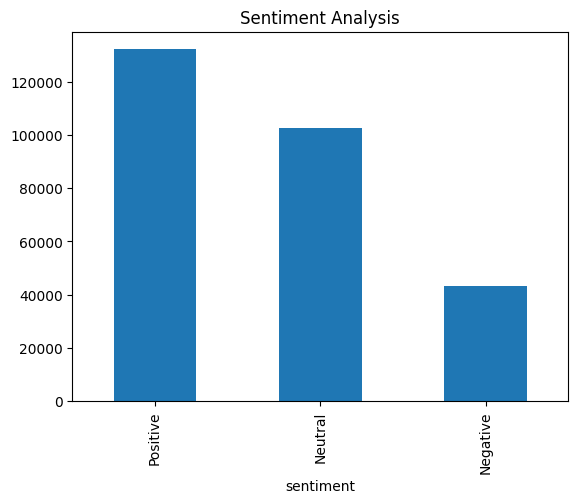

In [15]:
#the distribution of the sentiments from the dataset
df_work_clean['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Analysis')

# Sampling the dataframe

In [16]:
#Sample 4000 rows from the data
sample_df = df_work_clean.sample(n=3000)

In [17]:
#confirm the size of the randomly sampled dataframe
sample_df.shape

(3000, 47)

In [18]:
#confirm the columns 
sample_df.columns

Index(['id', 'conversation_id', 'referenced_tweets.retweeted.id', 'author_id',
       'retweeted_user_id', 'retweeted_username', 'created_at', 'text', 'lang',
       'public_metrics.impression_count', 'public_metrics.reply_count',
       'public_metrics.retweet_count', 'public_metrics.quote_count',
       'public_metrics.like_count', 'reply_settings', 'edit_history_tweet_ids',
       'edit_controls.edits_remaining', 'edit_controls.editable_until',
       'edit_controls.is_edit_eligible', 'possibly_sensitive',
       'entities.annotations', 'entities.hashtags', 'entities.mentions',
       'entities.urls', 'context_annotations', 'attachments.media',
       'attachments.media_keys', 'author.id', 'author.created_at',
       'author.username', 'author.name', 'author.description',
       'author.entities.url.urls', 'author.url', 'author.location',
       'author.pinned_tweet_id', 'author.profile_image_url',
       'author.protected', 'author.public_metrics.followers_count',
       'author.pu

In [19]:
sample_df.head().transpose()

,187528,345475,101334,140414,378105
id,1594667513249501184,1594000313350238209,1595822007278608384,1595066824223297538,1592612223238930433
conversation_id,1594667513249501184,1594000313350238209,1595822007278608384,1595066824223297538,1592612223238930433
referenced_tweets.retweeted.id,1594444953547046912.0,1593514722917289984.0,1595796477217017856.0,1592109838854676480.0,1592543108528746496.0
author_id,303914963,38845292,1357928252,4809870110,148766645
retweeted_user_id,2788662084.0,52364719.0,1313789948282142720.0,24006034.0,136001294.0
retweeted_username,TheFrackingGuy,EPAIreland,Shearwater_Glob,TNInstitute,ITDP_HQ
created_at,2022-11-21T12:22:17.000Z,2022-11-19T16:11:04.000Z,2022-11-24T16:49:50.000Z,2022-11-22T14:49:00.000Z,2022-11-15T20:15:17.000Z
text,Why doesn’t Germany just turn its wind turbine...,Climate Change’s Four Irelands are: The Doubtf...,The ocean was name checked in the final declar...,🚨 BREAKING: Richest polluting nations are spen...,The #CompactCities Roadmaps are a new series a...
lang,en,en,en,en,en
public_metrics.impression_count,0,0,0,0,0


In [20]:
# Create the instance and graph of Networkx from the DataFrame
G = nx.from_pandas_edgelist(sample_df, 'author.username', 'retweeted_username', edge_attr='public_metrics.retweet_count', create_using=nx.DiGraph)
#G = nx.from_pandas_edgelist(temp_df, 'author.username', 'retweeted_username', edge_attr=True, create_using=nx.DiGraph)

#check the nodes
G.nodes()

NodeView(('HenryK_B_', 'TheFrackingGuy', 'CharlesSpillane', 'EPAIreland', 'peterguilford', 'Shearwater_Glob', 'Perry_OB', 'TNInstitute', 'AKAalphonse', 'ITDP_HQ', 'TeckVado', 'AI4Good', 'marcelocapela', 'santanna_cs', 'vicentclausell', 'castelloenbici', 'StephanieHosier', 'exxonmobil', 'jeanninesgesser', 'MarcusWadsak', 'RobertBedner', 'WilliamJRipple', 'princepapa1', 'LaudatoSiMvmt', 'ynakenya', 'WMBtweets', 'TheAgenda', 'EcopiaAI', 'Tecasilva2', 'MimiChiavegato', 'UlverJ', 'PCarterClimate', 'gkirschner91', 'ProfMarkMaslin', 'bbd9f097b938458', 'dolphin_angels', 'Citizen4Sustain', 'climatalk_org', 'RevathyPurusho2', 'SadhguruTamil', 'lntongai', 'JoinIsmail', 'ReviewsMB', 'AnikaMolesworth', 'FurusetGerden', 'Greenpeace', 'IjazSarwan', 'BBhuttoZardari', 'WadeMuslim', 'pRiNCeSseQa_MQD', 'ruthmagin', 'EarthAccounting', 'mkah', 'IOM_MECC', 'SabaSal16420944', 'SarwarFdn', 'ncontsi', 'UNBiodiversity', 'lebalzin', 'MIGA', 'Climatepledgeco', 'JustStop_Oil', 'fischer112', 'NicolasMaduro', 'J_Koh

In [21]:
#check the edges
G.edges()

OutEdgeView([('HenryK_B_', 'TheFrackingGuy'), ('CharlesSpillane', 'EPAIreland'), ('peterguilford', 'Shearwater_Glob'), ('Perry_OB', 'TNInstitute'), ('AKAalphonse', 'ITDP_HQ'), ('TeckVado', 'AI4Good'), ('marcelocapela', 'santanna_cs'), ('vicentclausell', 'castelloenbici'), ('StephanieHosier', 'exxonmobil'), ('jeanninesgesser', 'MarcusWadsak'), ('RobertBedner', 'WilliamJRipple'), ('princepapa1', 'LaudatoSiMvmt'), ('ynakenya', 'WMBtweets'), ('TheAgenda', 'EcopiaAI'), ('Tecasilva2', 'MimiChiavegato'), ('UlverJ', 'PCarterClimate'), ('gkirschner91', 'ProfMarkMaslin'), ('bbd9f097b938458', 'dolphin_angels'), ('Citizen4Sustain', 'climatalk_org'), ('RevathyPurusho2', 'SadhguruTamil'), ('lntongai', 'JoinIsmail'), ('ReviewsMB', 'AnikaMolesworth'), ('FurusetGerden', 'Greenpeace'), ('FurusetGerden', 'UNEP'), ('IjazSarwan', 'BBhuttoZardari'), ('WadeMuslim', 'pRiNCeSseQa_MQD'), ('ruthmagin', 'EarthAccounting'), ('mkah', 'IOM_MECC'), ('SabaSal16420944', 'SarwarFdn'), ('ncontsi', 'UNBiodiversity'), ('nc

# Due to computational limitations, a modest value for max_iter was selected on the below code and results in the groupings of the communities not being optimally grouped

# The most influential users on the top 5 communities are labelled on the plot and listed below the plot

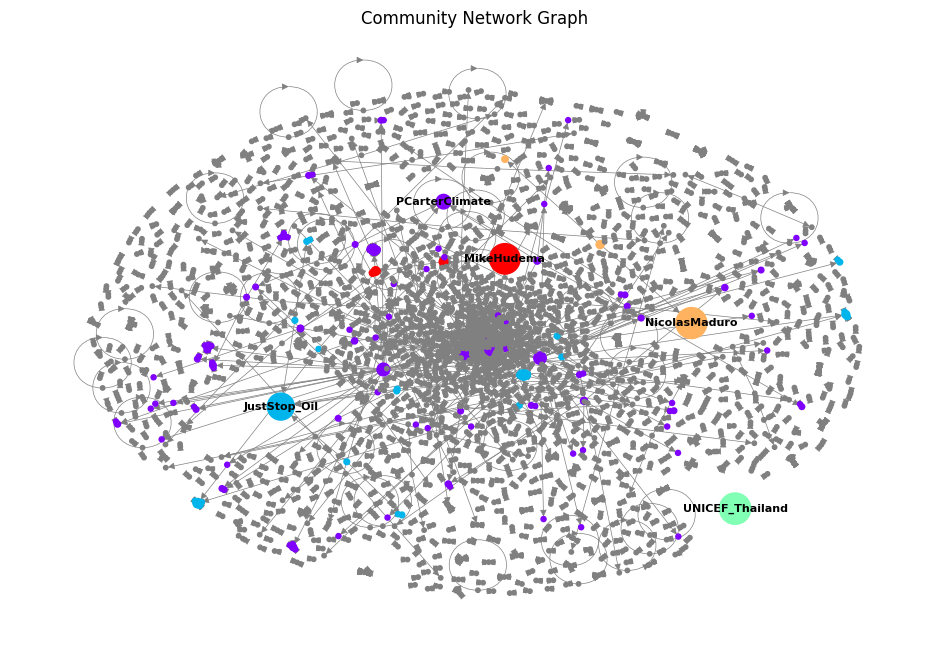

Most Influential Users in Top 5 Communities: {'Community 1': 'PCarterClimate', 'Community 2': 'JustStop_Oil', 'Community 3': 'UNICEF_Thailand', 'Community 4': 'NicolasMaduro', 'Community 5': 'MikeHudema'}

The time it took to compute and run the visual: 22.323 minutes


In [22]:

#start ime to be used to calculate how much time it takes to run the visualization. This is done as the dataset is big
start= time.time()

#girvan newman method to group the communities
communities = girvan_newman(G)

#filter the top 5 communities
top_communities = sorted(next(communities), key=len, reverse=True)[:5]

# Identify the most influential users within the top 5 communities
influential_users = {}
node_size = {}
for i, community in enumerate(top_communities):
    subgraph = G.subgraph(community)
    centrality = degree_centrality(subgraph)

    #scale the node sizes based on centrality 
    for node, cent in centrality.items(): 
        node_size[node] = 10 + cent * 500
        
    #find the user with the highest degree centrality in the community
    most_influential_user = max(centrality, key=centrality.get)
    influential_users[f'Community {i+1}'] = most_influential_user

#visualize the graph with community colors
pos = nx.forceatlas2_layout(G, max_iter=500)


#the colours for the different communities
num_communities = len(top_communities) 
colors = plt.cm.rainbow(np.linspace(0, 1, num_communities))

#initiate the colors and sizes lists for the nodes
node_colors = []
node_sizes = []

#iterate through the graph and apply the colours and sizes to the nodes, nodes not in the top 5 are coloured grey
for node in G.nodes():
    for i, community in enumerate(top_communities):
        if node in community:
            node_colors.append(colors[i % len(colors)])
            node_sizes.append(node_size.get(node, 10))
            break
    else:
        node_colors.append('grey')
        node_sizes.append(10)

# Prepare labels for the most influential users 
labels = {influential_user: influential_user for influential_user in influential_users.values()}

#initiate the plot area
plt.figure(figsize=(12, 8))
plt.title('Community Network Graph')

#draw the plot, colour and label the top influencers in the top 5 communities
nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, with_labels=False, edge_color='grey', width=0.5)
nx.draw_networkx_labels(G, pos, labels,font_size=8, font_color='black', font_weight='bold')
plt.show()

#print the names of the top influencers
print("Most Influential Users in Top 5 Communities:", influential_users)

#calculate how long it took to graph in minutes. 
print(f"\nThe time it took to compute and run the visual: {round((time.time() - start)/60, 3)} minutes")
